In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.json', 'train.json']


In [2]:
train = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace


# Analysis of photos

Although we can't use photos directly, we can see if number of photos has any relation to interest_level

In [3]:
train['num_photos'] = train.apply(lambda x: len(x.photos), axis=1)
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,num_photos
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,8
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,3
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,5
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,5


In [4]:
train.num_photos.describe()

count    39481.000000
mean         5.615739
std          3.620307
min          0.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         68.000000
Name: num_photos, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


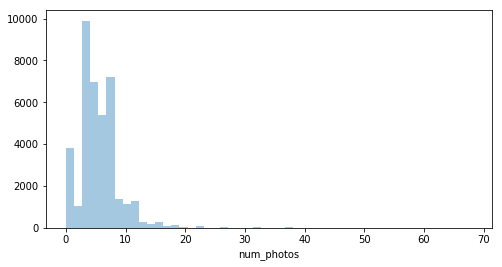

In [5]:
plt.figure(figsize=(8,4))
sns.distplot(train.num_photos, kde=False)
plt.show()

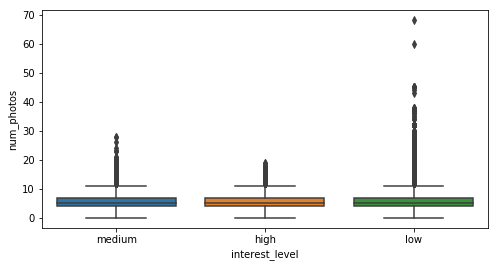

In [6]:
plt.figure(figsize=(8,4))
sns.boxplot(x='interest_level', y='num_photos', data=train)
plt.show()

In [7]:
train.groupby('interest_level').num_photos.mean()

interest_level
high      5.768705
low       5.530649
medium    5.825297
Name: num_photos, dtype: float64

In [8]:
train.groupby('interest_level').num_photos.std()

interest_level
high      2.699059
low       3.960618
medium    2.662459
Name: num_photos, dtype: float64

There doesn't seem to be a direct co-relation between interest_level and number of photos if interest_level is given an ordering. But from the boxplot, appartments having a large number of photos usually have low interest.

# Analysis of Manager Id

In [9]:
train_man = train.manager_id.unique()
test_man = test.manager_id.unique()

print("Number of unique managers in train:", len(train_man))
print("Number of unique managers in test:", len(test_man))

Number of unique managers in train: 3292
Number of unique managers in test: 2020


In [10]:
print("Number of managers common:", len(set(train_man) & set(test_man)))

Number of managers common: 1831


Most of the managers in test are in train also. So it might be good to have manager_id as a feature

I also established that the same managers have high number of apartments in both test and train. The cells got deleted by mistake. Look at previous versions. Those versions will also have other inferences based on the analysis.

In [11]:
man_df = pd.crosstab(train.manager_id, train.interest_level)

In [12]:
man_df.isna().sum()

interest_level
high      0
low       0
medium    0
dtype: int64

In [13]:
man_df.fillna(0, inplace=True)
man_df.head()

interest_level,high,low,medium
manager_id,,,
0000abd7518b94c35a90d64b56fbf3e6,0,3,8
001ce808ce1720e24a9510e014c69707,0,8,0
003fc4e9a70053082f131b1054966aaf,0,1,0
00607a02f6efd9c6c7c588826e471ee9,0,0,2
00995ff28d79127ed2dca8320e9e7d09,0,2,1


Maybe combining number of high and medium to consider how good the manager is will work.

In [14]:
intgp = train.groupby('interest_level').size()
intgp = intgp.apply(lambda x: train.shape[0] / x)
print(intgp)

interest_level
high      12.843526
low        1.436247
medium     4.427114
dtype: float64


The idea is to give weightage to each class inversely proportional to its occurence.

In [15]:
man_df['man_ability'] = sum([intgp[i] * man_df[i] for i in ['high', 'low', 'medium']])

In [16]:
man_df.head()

interest_level,high,low,medium,man_ability
manager_id,,,,
0000abd7518b94c35a90d64b56fbf3e6,0,3,8,39.725651
001ce808ce1720e24a9510e014c69707,0,8,0,11.489978
003fc4e9a70053082f131b1054966aaf,0,1,0,1.436247
00607a02f6efd9c6c7c588826e471ee9,0,0,2,8.854227
00995ff28d79127ed2dca8320e9e7d09,0,2,1,7.299608


In [17]:
train = pd.merge(train, man_df[['man_ability']], on='manager_id')
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,num_photos,man_ability
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5,151.500408
1,1.0,1,0,2016-04-18 03:31:04,GUT Renovated Greenpoint 1 bedroom with brand ...,Meeker Avenue,[New Construction],low,40.7216,30797,-73.9423,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/6890059_a3109b80...,2250,585 Meeker Avenue,5,151.500408
2,1.0,1,0,2016-04-02 03:09:43,Small building of just 8 apartments!<br /><br ...,Himrod Street,[],medium,40.6963,21576,-73.9239,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/6814785_e611ba1d...,1950,93 Himrod Street,4,151.500408
3,1.0,1,0,2016-04-28 05:49:14,Renovated 1 Bedroom with Southern Exposure<br ...,Wyckoff Avenue,[],low,40.7056,47383,-73.9209,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/6938079_6c16a41a...,2000,71 Wyckoff Avenue,4,151.500408
4,1.0,1,0,2016-04-18 02:49:24,Massive 1 Bedroom Apartment<br /><br />Recent ...,Bushwick Avenue,[Laundry in Building],low,40.6884,44387,-73.9168,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/6889275_c801d1ed...,1800,1180 Bushwick Avenue,4,151.500408


In [18]:
train.groupby('interest_level').man_ability.mean()

interest_level
high      514.961987
low       457.394554
medium    550.098360
Name: man_ability, dtype: float64

In [19]:
train.groupby('interest_level').man_ability.std()

interest_level
high      1242.839310
low       1287.248097
medium    1347.800564
Name: man_ability, dtype: float64

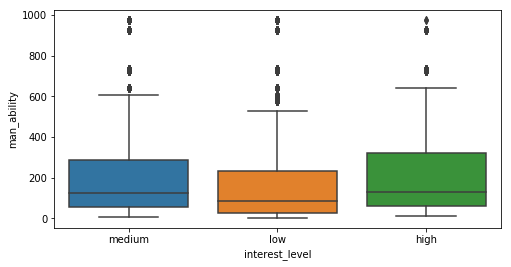

In [20]:
plt.figure(figsize=(8,4))
sns.boxplot(x='interest_level', y='man_ability', data=train[train.man_ability < 1000])
plt.show()

Again there doesn't seem to be any direct co-relation between interest_level and ability if interest_level is considered with ordering, but it might be a good way to capture manager_id.

# Analysis of number of features

In [21]:
train = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')

In [22]:
train['num_features'] = train.apply(lambda x: len(x.features), axis=1)
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,num_features
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,0
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,4
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,2
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,0
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,4


In [23]:
train.num_features.describe()

count    39481.000000
mean         5.444340
std          3.926935
min          0.000000
25%          2.000000
50%          5.000000
75%          8.000000
max         39.000000
Name: num_features, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


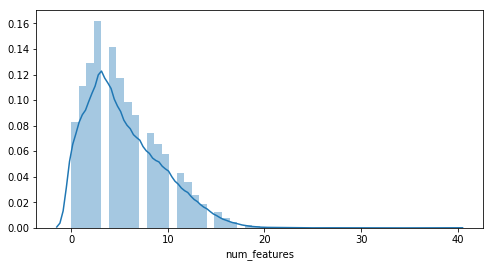

In [24]:
plt.figure(figsize=(8,4))
sns.distplot(train.num_features)
plt.show()

The number of features seems to be a skewed distiribution and has a lot of gaps.

In [25]:
train.groupby('interest_level').num_features.mean()

interest_level
high      5.185426
low       5.322966
medium    5.907715
Name: num_features, dtype: float64

In [26]:
train.groupby('interest_level').num_features.std()

interest_level
high      4.157269
low       3.830864
medium    4.098390
Name: num_features, dtype: float64

Number of features doesn't seem extremely useful. Moreover this is captured in by our vectorizer to a certain extent. This was a feature in our basic models.

** Seems to me, it makes more sense to not associate an ordering to the interest levels i.e. consider high, low and medium as three classes instead of considering high to me "more" than the other two. It's counter-intuitive, but most of our features support this.**

In [27]:
from  itertools import chain

feat_df = pd.DataFrame({
        "interest_level": np.repeat(train.interest_level.values, train.features.str.len()),
        "listing_id": np.repeat(train.listing_id.values, train.features.str.len()),
        "features": list(chain.from_iterable(train.features))})
feat_df.head()

,interest_level,listing_id,features
0,high,6727,Laundry In Building
1,high,6727,Dishwasher
2,high,6727,Hardwood Floors
3,high,6727,Pets Allowed Case by Case
4,low,38446,Hardwood Floors


In [28]:
len(feat_df.features.unique())

1336

In [29]:
feat_df.features.value_counts()

Elevator                                                                                                                      20780
Hardwood Floors                                                                                                               18896
Cats Allowed                                                                                                                  18870
Dogs Allowed                                                                                                                  17658
Doorman                                                                                                                       16724
Dishwasher                                                                                                                    16388
No Fee                                                                                                                        14418
Laundry in Building                                                         

In [30]:
feat_df['tfeat'] = feat_df.apply(lambda x: x.features.lower(), axis=1)
feat_df.head()

,interest_level,listing_id,features,tfeat
0,high,6727,Laundry In Building,laundry in building
1,high,6727,Dishwasher,dishwasher
2,high,6727,Hardwood Floors,hardwood floors
3,high,6727,Pets Allowed Case by Case,pets allowed case by case
4,low,38446,Hardwood Floors,hardwood floors


In [31]:
len(feat_df.tfeat.unique())

1119

In [32]:
feat_df.tfeat.value_counts().tail(100)

near transportation                                                                                                       1
private lounge w/ wet bar & billiards table                                                                               1
** massive 1br home * rent stabilized * separate kitchen * walls of windows * roomy closets **                            1
hardwood  floors                                                                                                          1
open concept kitchen                                                                                                      1
available  04/15/16                                                                                                       1
gut renovations                                                                                                           1
window bathroom                                                                                                           1
mins fro

In [33]:
feat_df.tfeat = feat_df.apply(lambda x: re.sub('[^A-Za-z0-9 ]', ' ', x.tfeat), axis=1)
feat_df.head()

,interest_level,listing_id,features,tfeat
0,high,6727,Laundry In Building,laundry in building
1,high,6727,Dishwasher,dishwasher
2,high,6727,Hardwood Floors,hardwood floors
3,high,6727,Pets Allowed Case by Case,pets allowed case by case
4,low,38446,Hardwood Floors,hardwood floors


In [34]:
len(feat_df.tfeat.unique())

1088

In [35]:
feat_df.tfeat.value_counts()

elevator                                                                                                                                                                                                21072
hardwood floors                                                                                                                                                                                         18920
cats allowed                                                                                                                                                                                            18870
dogs allowed                                                                                                                                                                                            17658
doorman                                                                                                                                                                         

In [36]:
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(x):
    wlist = x.split(' ')
    return " ".join(filter(lambda y: y not in stopwords, wlist))

feat_df.tfeat = feat_df.apply(lambda x: remove_stopwords(x.tfeat), axis=1)
feat_df.head()

,interest_level,listing_id,features,tfeat
0,high,6727,Laundry In Building,laundry building
1,high,6727,Dishwasher,dishwasher
2,high,6727,Hardwood Floors,hardwood floors
3,high,6727,Pets Allowed Case by Case,pets allowed case case
4,low,38446,Hardwood Floors,hardwood floors


In [37]:
len(feat_df.tfeat.unique())

1075

In [38]:
feat_df.tfeat.value_counts()

elevator                                                                                                                                  21072
hardwood floors                                                                                                                           18920
cats allowed                                                                                                                              18870
dogs allowed                                                                                                                              17658
doorman                                                                                                                                   16783
dishwasher                                                                                                                                16690
laundry building                                                                                                                        

In [39]:
stemmer = nltk.PorterStemmer()
def stemfeat(x):
    z = x.split()
    z = map(stemmer.stem, z)
    z = filter(lambda y: len(y) > 2, z)
    z = map(lambda y: y.strip(), z)
    return " ".join(z)

feat_df.tfeat = feat_df.apply(lambda x: stemfeat(x.tfeat), axis=1)
feat_df.head()

,interest_level,listing_id,features,tfeat
0,high,6727,Laundry In Building,laundri build
1,high,6727,Dishwasher,dishwash
2,high,6727,Hardwood Floors,hardwood floor
3,high,6727,Pets Allowed Case by Case,pet allow case case
4,low,38446,Hardwood Floors,hardwood floor


In [40]:
len(feat_df.tfeat.unique())

978

An overview of features leads me to believe that most features consist of 2 words. We'll thus use bigram for extracting individual features

In [41]:
def ngramize(x):
    z = x.split()
    if len(z) == 0:
        return [("")]
    elif len(z) < 2:
        return [(z[0], '')]
    return list(nltk.ngrams(z, 2))

feat_df["bigrams"] = feat_df.apply(lambda x: ngramize(x.tfeat), axis=1)
feat_df.head()

,interest_level,listing_id,features,tfeat,bigrams
0,high,6727,Laundry In Building,laundri build,"[(laundri, build)]"
1,high,6727,Dishwasher,dishwash,"[(dishwash, )]"
2,high,6727,Hardwood Floors,hardwood floor,"[(hardwood, floor)]"
3,high,6727,Pets Allowed Case by Case,pet allow case case,"[(pet, allow), (allow, case), (case, case)]"
4,low,38446,Hardwood Floors,hardwood floor,"[(hardwood, floor)]"


In [42]:
featbg = pd.DataFrame({
        "interest_level": np.repeat(feat_df.interest_level.values, feat_df.bigrams.str.len()),
        "listing_id": np.repeat(feat_df.listing_id.values, feat_df.bigrams.str.len()),
        "tfeat": np.repeat(feat_df.tfeat.values, feat_df.bigrams.str.len()),
        "bigrams": list(chain.from_iterable(feat_df.bigrams))})
featbg.head()

,interest_level,listing_id,tfeat,bigrams
0,high,6727,laundri build,"(laundri, build)"
1,high,6727,dishwash,"(dishwash, )"
2,high,6727,hardwood floor,"(hardwood, floor)"
3,high,6727,pet allow case case,"(pet, allow)"
4,high,6727,pet allow case case,"(allow, case)"


In [43]:
featbg.bigrams = featbg.apply(lambda x: ' '.join(x.bigrams), axis=1)
featbg.head()

,interest_level,listing_id,tfeat,bigrams
0,high,6727,laundri build,laundri build
1,high,6727,dishwash,dishwash
2,high,6727,hardwood floor,hardwood floor
3,high,6727,pet allow case case,pet allow
4,high,6727,pet allow case case,allow case


In [44]:
featbg.bigrams.value_counts()

elev                     21072
hardwood floor           18931
cat allow                18870
dog allow                17658
doorman                  16815
dishwash                 16690
laundri build            15224
fee                      14439
fit center               10630
laundri unit              7595
pre war                   7366
outdoor space             5766
roof deck                 5664
dine room                 4188
high speed                3483
speed internet            3482
balconi                   2464
swim pool                 2208
new construct             2094
terrac                    1865
exclus                    1738
loft                      1686
garden patio              1574
wheelchair access         1084
prewar                    1079
common outdoor            1072
hardwood                   838
fireplac                   747
simplex                    724
high ceil                  649
                         ...  
west villag                  1
close ce

In [45]:
len(featbg.bigrams.unique())

1882

# Analysis of description

In [46]:
train = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')

In [47]:
len(train.description.unique())

31358

In [48]:
train.description.value_counts()

I think some managers add the same descriptions to all items. Maybe we can verify later.

## Number of words in caps

In [49]:
train["num_caps_desc"] = train.description.apply(lambda x: sum(1 for c in x.split() if c.isupper()))
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,num_caps_desc
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,1
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,1
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,0
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,0


In [50]:
train.groupby("interest_level").num_caps_desc.mean()

interest_level
high      12.259597
low        9.165157
medium    14.860395
Name: num_caps_desc, dtype: float64

In [51]:
train.groupby("interest_level").num_caps_desc.std()

interest_level
high      24.58579
low       21.00764
medium    27.69983
Name: num_caps_desc, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


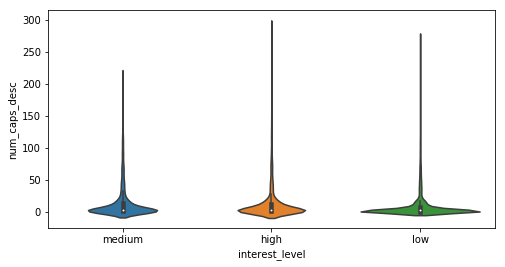

In [52]:
plt.figure(figsize=(8,4))
sns.violinplot(x='interest_level', y='num_caps_desc', data=train)
plt.show()

Doesn't seem like num_caps_desc is helpful

## Ratio of upper to lower characters

In [53]:
def up_low_ratio(x):
    up = 0
    low = 0
    for i in x:
        if i.isupper():
            up += 1
        elif i.islower():
            low += 1
    return (up+1)/(low+1)

train["up_low_ratio"] = train.description.apply(up_low_ratio)
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,num_caps_desc,up_low_ratio
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5,0.164021
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,1,0.036398
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,1,0.080645
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,0,1.000000
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,0,0.055556


In [54]:
train.groupby("interest_level").up_low_ratio.mean()

interest_level
high      1.625393
low       1.135897
medium    1.929370
Name: up_low_ratio, dtype: float64

In [55]:
train.groupby("interest_level").up_low_ratio.std()

interest_level
high      17.923592
low       12.843431
medium    19.339200
Name: up_low_ratio, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


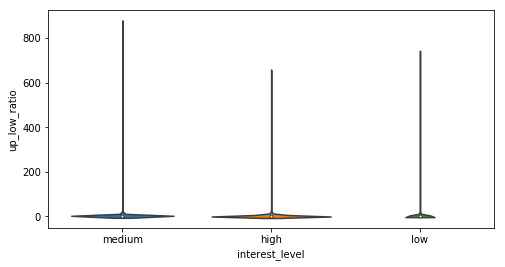

In [56]:
plt.figure(figsize=(8,4))
sns.violinplot(x='interest_level', y='up_low_ratio', data=train)
plt.show()

## Number of special characters

In [57]:
train["count_spchar"] = train.description.apply(lambda x: len(re.findall('[!#$^&*<>=]', x)))
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,num_caps_desc,up_low_ratio,count_spchar
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5,0.164021,17
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,1,0.036398,25
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,1,0.080645,45
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,0,1.000000,0
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,0,0.055556,3


In [58]:
train.groupby("interest_level").count_spchar.mean()

interest_level
high      16.839623
low       14.942959
medium    18.292554
Name: count_spchar, dtype: float64

In [59]:
train.groupby("interest_level").count_spchar.std()

interest_level
high      17.759246
low       15.615746
medium    15.790578
Name: count_spchar, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


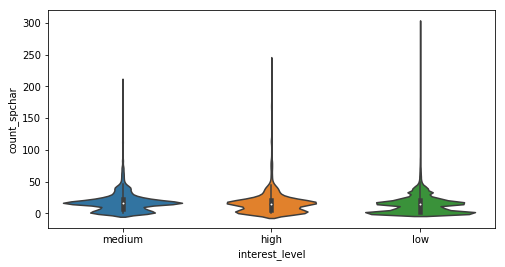

In [60]:
plt.figure(figsize=(8,4))
sns.violinplot(x='interest_level', y='count_spchar', data=train)
plt.show()

In [61]:
train["tdesc"] = train.description.apply(lambda x: x.lower())
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,num_caps_desc,up_low_ratio,count_spchar,tdesc
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5,0.164021,17,a brand new 3 bedroom 1.5 bath apartmentenjoy ...
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,1,0.036398,25,"top top west village location, beautiful pre-w..."
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,1,0.080645,45,building amenities - garage - garden - fitness...
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,0,1.000000,0,
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,0,0.055556,3,<p><a website_redacted


In [62]:
len(train.tdesc.unique())

31333

In [63]:
# Remove HTML tags
train.tdesc = train.apply(lambda x: re.sub('<.*?>', ' ', x.tdesc), axis=1)
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,num_caps_desc,up_low_ratio,count_spchar,tdesc
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5,0.164021,17,a brand new 3 bedroom 1.5 bath apartmentenjoy ...
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,1,0.036398,25,"top top west village location, beautiful pre-w..."
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,1,0.080645,45,building amenities - garage - garden - fitness...
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,0,1.000000,0,
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,0,0.055556,3,<a website_redacted


In [64]:
train.tdesc = train.apply(lambda x: re.sub('[^A-Za-z0-9 ]', ' ', x.tdesc), axis=1)
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,num_caps_desc,up_low_ratio,count_spchar,tdesc
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5,0.164021,17,a brand new 3 bedroom 1 5 bath apartmentenjoy ...
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,1,0.036398,25,top top west village location beautiful pre w...
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,1,0.080645,45,building amenities garage garden fitness...
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,0,1.000000,0,
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,0,0.055556,3,a website redacted


In [65]:
len(train.tdesc.unique())

31159

In [66]:
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(x):
    wlist = x.split()
    return " ".join(filter(lambda y: y not in stopwords, wlist))

train.tdesc = train.tdesc.apply(lambda x: remove_stopwords(x))
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,num_caps_desc,up_low_ratio,count_spchar,tdesc
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5,0.164021,17,brand new 3 bedroom 1 5 bath apartmentenjoy fo...
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,1,0.036398,25,top top west village location beautiful pre wa...
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,1,0.080645,45,building amenities garage garden fitness room ...
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,0,1.000000,0,
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,0,0.055556,3,website redacted


In [67]:
stemmer = nltk.PorterStemmer()
def stemfeat(x):
    z = x.split()
    z = map(stemmer.stem, z)
    z = filter(lambda y: len(y) > 2, z)
    z = map(lambda y: y.strip(), z)
    return " ".join(z)

train.tdesc = train.tdesc.apply(lambda x: stemfeat(x))
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,num_caps_desc,up_low_ratio,count_spchar,tdesc
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5,0.164021,17,brand new bedroom bath apartmentenjoy follow a...
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,1,0.036398,25,top top west villag locat beauti pre war build...
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,1,0.080645,45,build amen garag garden fit room laundri room ...
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,0,1.000000,0,
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,0,0.055556,3,websit redact


In [68]:
len(train.tdesc.unique())

30577

# Display Address

In [69]:
train = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')

In [70]:
len(train.display_address.unique())

7644

In [71]:
train.display_address.value_counts()

Broadway                                                    339
Second Avenue                                               287
East 34th Street                                            282
Wall Street                                                 280
West 37th Street                                            230
West Street                                                 211
Gold Street                                                 202
First Avenue                                                190
Washington Street                                           186
York Avenue                                                 175
Water Street                                                171
John Street                                                 161
East 39th Street                                            160
East 89th Street                                            155
West 42nd Street                                            152
West 54th Street                        

In [72]:
stemmer = nltk.PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

def clean_display_address(t):
    x = t.lower()
    x = re.sub('[^A-Za-z0-9 ]', ' ', x)
    z = x.split()
    z = map(stemmer.stem, z)
    z = filter(lambda y: len(y) > 2, z)
    z = map(lambda y: y.strip(), z)
    z = " ".join(z)
    z = z.split()
    return " ".join(filter(lambda y: y not in stopwords, z))

train["tdispadd"] = train.display_address.apply(clean_display_address)
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,tdispadd
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,metropolitan avenu
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,east 49th street
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,west 18th street
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,hamilton terrac


In [73]:
len(train.tdispadd.unique())

4876

In [74]:
train.tdispadd.value_counts()

street                      2567
                            2481
broadway                     351
ave                          336
wall street                  300
second avenu                 290
east 34th street             282
west street                  252
west 37th street             232
gold street                  214
avenu                        193
first avenu                  192
washington street            189
york avenu                   176
water street                 174
john street                  168
east 39th street             160
west 42nd street             158
east 89th street             157
lexington avenu              153
west 54th street             152
fifth avenu                  151
west 34th street             150
christoph street             148
west                         147
east 35th street             146
columbu avenu                145
east 29th street             144
east 46th street             141
west end avenu               139
          

Seems like a good attribute although there's a bit of noise, but that will be removed if we set a max_feature param while training

# Street Address

In [75]:
train = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')

In [76]:
len(train.street_address.unique())

13451

In [77]:
train.street_address.value_counts()

3333 Broadway            136
505 West 37th Street     134
200 Water Street         128
90 Washington Street     116
401 East 34th Street     108
100 Maiden Lane          104
2 Gold Street            101
1 West Street             95
95 Wall Street            88
340 East 29th Street      87
100 John Street           84
50 West 34th Street       81
8 Spruce Street           74
95 Christopher Street     71
166 Second Avenue         68
888 Eighth Avenue         67
10 Hanover Square         67
145 East 16th Street      66
505 W 37 St.              64
550 West 54th Street      64
1 West St.                62
140 East 46th Street      62
236 East 36th Street      60
45 Wall Street            58
200 East 72nd Street      57
360 West 34th Street      57
561 10 Ave.               57
1 Astor Place             55
323 W 96 St.              52
260 West 54th Street      51
                        ... 
446 East 78th Street       1
257 15th Street            1
86 east 4                  1
11-25 46th Rd 

In [78]:
transform = {
            "street": "st",
            "st.": "st",
            "west": "w",
            "east": "e",
            "south": "s",
            "north": "n"
        }

def clean_street_address(t):
    x = t.lower()
    x = re.sub('[^A-Za-z0-9 ]', ' ', x)
    z = x.split()
    z = map(lambda y: y.strip(), z)
    z = map(lambda y: transform.get(y, y), z)
    z = " ".join(z)
    return z

train["tstreetadd"] = train.street_address.apply(clean_street_address)
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,tstreetadd
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,792 metropolitan avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,241 w 13 st
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,333 e 49th st
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,350 w 18th st
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,63 hamilton terrace


In [79]:
len(train.tstreetadd.unique())

10366

In [80]:
train.tstreetadd.value_counts()

1 w st                                   176
200 water st                             171
505 w 37th st                            158
90 washington st                         151
401 e 34th st                            140
3333 broadway                            137
2 gold st                                132
100 john st                              120
95 wall st                               119
100 maiden lane                          112
8 spruce st                              112
340 e 29th st                            108
50 w 34th st                              98
95 christopher st                         98
200 e 72nd st                             86
145 e 16th st                             85
45 wall st                                84
550 w 54th st                             83
360 w 34th st                             83
620 w 42nd st                             82
116 john st                               82
140 e 46th st                             80
165 e 35th

In [81]:
train["tstreetadd"] = train.tstreetadd.apply(lambda y: y.lstrip('0123456789 '))
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,tstreetadd
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,34633,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,metropolitan avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6727,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,w 13 st
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,38446,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,e 49th st
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,2808,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,w 18th st
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,21731,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,hamilton terrace


In [82]:
len(train.tstreetadd.unique())

2669

In [83]:
train.tstreetadd.value_counts()

th st                                      493
th ave                                     413
wall st                                    391
broadway                                   371
e 34th st                                  368
w st                                       365
w 37th st                                  316
th avenue                                  305
second avenue                              304
gold st                                    301
john st                                    272
ave                                        265
w 42nd st                                  265
washington st                              247
e 39th st                                  239
water st                                   233
w 54th st                                  227
e 35th st                                  216
e 46th st                                  215
w 34th st                                  213
york avenue                                211
e 79th st    

# Price per rooms

In [84]:
train = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')

In [85]:
train["ppbedroom"] = (train.price + 1) / (train.bedrooms + 1)

In [86]:
train.groupby('interest_level').ppbedroom.mean()

interest_level
high      1223.670597
low       1790.074022
medium    1359.903195
Name: ppbedroom, dtype: float64

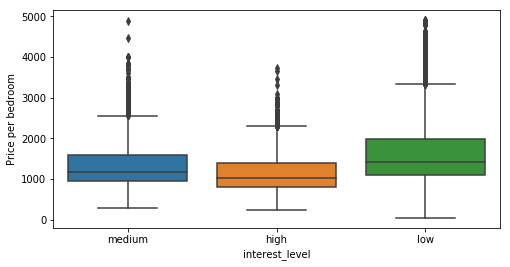

In [87]:
plt.figure(figsize=(8,4))
sns.boxplot(x='interest_level', y='ppbedroom', data=train[(train.price < 5000) & (train.price > 43)]) # Remove outliers
plt.ylabel("Price per bedroom")
plt.show()

In [88]:
train["ppbathroom"] = (train.price + 1) / (train.bathrooms + 1)

In [89]:
train.groupby('interest_level').ppbathroom.mean()

interest_level
high      1278.220923
low       1815.228086
medium    1448.178350
Name: ppbathroom, dtype: float64

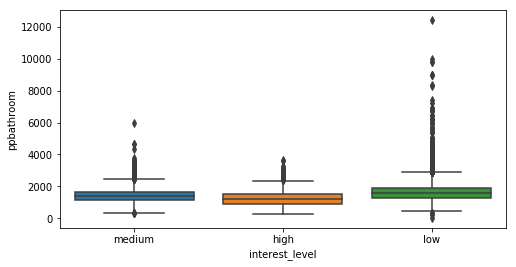

In [90]:
plt.figure(figsize=(8,4))
sns.boxplot(x='interest_level', y='ppbathroom', data=train[(train.price < 15000) & (train.price > 43)]) # Remove outliers
plt.show()

In [91]:
train["pprooms"] = (train.price + 1) / (train.bathrooms + train.bedrooms + 1)

In [92]:
train.groupby('interest_level').pprooms.mean()

interest_level
high       774.849968
low       1130.895046
medium     869.487851
Name: pprooms, dtype: float64

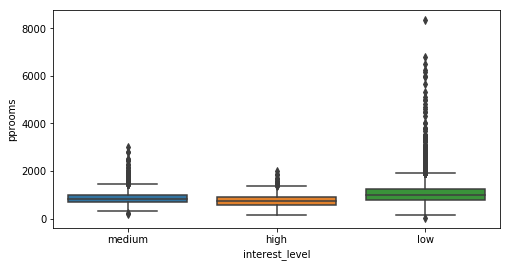

In [93]:
plt.figure(figsize=(8,4))
sns.boxplot(x='interest_level', y='pprooms', data=train[(train.price < 15000) & (train.price > 43)]) # Remove outliers
plt.show()